In [1]:
# CIFAR 10 Dataset

In [28]:
# Import libraries
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
import tensorflow as tf
from matplotlib import pyplot
from keras.models import model_from_json
from matplotlib.pyplot import imshow

In [3]:
# Dataset
from keras.datasets import cifar10

In [4]:
# Load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [30]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 10)
(10000, 10)


In [6]:
def show_images(x):
    pyplot.figure(1)
    k = 0
    for i in range(0, 4):
        for j in range(0,4):
            pyplot.subplot2grid((4,4), (i,j))
            pyplot.imshow(x[k])
            k = k+1
    pyplot.show()

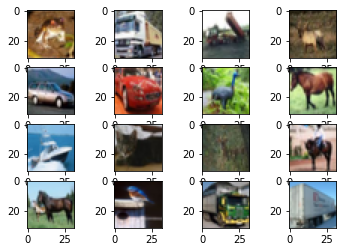

In [7]:
show_images(x_train[:16])

In [8]:
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

In [9]:
# Normalization using z-score ===>x-U/sigma
mean = np.mean(x_train, axis = (0,1,2,3))
std = np.std(x_train, axis = (0,1,2,3))

In [10]:
x_train = (x_train - mean) / (std+1e-7)
x_test = (x_test - mean) / (std+1e-7)

In [11]:
num_classes = 10

In [12]:
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [13]:
# Weight decay
weight_decay = 1e-4

In [14]:
# Modeling and pooling
model = Sequential()
model.add(Conv2D(32, (3,3), padding = "same",
                kernel_regularizer = regularizers.l2(weight_decay),
                input_shape = x_train.shape[1:]))

model.add(Activation("elu"))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3), padding = "same",
                kernel_regularizer = regularizers.l2(weight_decay)))

model.add(Activation("elu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(.2))


In [15]:
model = Sequential()
model.add(Conv2D(64, (3,3), padding = "same",
                kernel_regularizer = regularizers.l2(weight_decay),
                input_shape = x_train.shape[1:]))

model.add(Activation("elu"))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3), padding = "same",
                kernel_regularizer = regularizers.l2(weight_decay)))

model.add(Activation("elu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(.3))

In [16]:
model = Sequential()
model.add(Conv2D(128, (3,3), padding = "same",
                kernel_regularizer = regularizers.l2(weight_decay),
                input_shape = x_train.shape[1:]))

model.add(Activation("elu"))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3), padding = "same",
                kernel_regularizer = regularizers.l2(weight_decay)))

model.add(Activation("elu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(.4))

In [17]:
# Flatten the output from pooling
model.add(Flatten())

In [18]:
model.add(Dense(num_classes, activation = "softmax"))

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 activation_4 (Activation)   (None, 32, 32, 128)       0         
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 activation_5 (Activation)   (None, 32, 32, 128)       0         
                                                                 
 batch_normalization_5 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                      

In [20]:
# Learning scheduler
def lr_scheduler(epoch):
    lrate = .001
    if epoch > 75:
        lrate = .0005
    if epoch > 100:
            lrate = .0003
    return lrate

In [21]:
# Data augmentation
datagen = ImageDataGenerator(
rotation_range = 15,
width_shift_range = .1,
height_shift_range = .1,
horizontal_flip = True)

In [22]:
datagen.fit(x_train)

In [31]:
# Training 
batch_size = 64
opt_rms = tf.keras.optimizers.RMSprop(lr = .0003, decay = 1e-6)
model.compile(loss = "categorical_crossentropy", optimizer = opt_rms,
             metrics = ["accuracy"])
model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size),
                   steps_per_epoch = x_train.shape[0]//batch_size, epochs = 2, # usually a higher # of epochs, slow computer
                   # The more epochs you generate, the higher the accuracy
                   verbose = 1, validation_data=(x_test, y_test))

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_16036/306107307.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size),


Epoch 1/2
781/781 [==============================] - 1741s 2s/step - loss: 2.8274 - accuracy: 0.3730 - val_loss: 2.3221 - val_accuracy: 0.4846
Epoch 2/2
781/781 [==============================] - 1709s 2s/step - loss: 2.3389 - accuracy: 0.4504 - val_loss: 1.8905 - val_accuracy: 0.5454


In [40]:
# Saving the model 
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [41]:
model.save_weights("CNNModelFinal.h5")

In [47]:
# Loading trained CNN model
json_file = open("model.json", "r")

In [48]:
from keras.models import model_from_json

In [49]:
loaded_model_json = json_file.read()

In [50]:
json_file.close()

In [51]:
saved_model = model_from_json(loaded_model_json)

In [52]:
saved_model.load_weights("CNNModelFinal.h5")

In [53]:
labels = ["airplane", "automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [54]:
len(labels)

10

In [55]:
indices = np.argmax(saved_model.predict(x_test[:16]), 1)

In [56]:
print([labels[x] for x in indices]) # prints the labels from highest to lowest count order for the test rows

['dog', 'automobile', 'ship', 'ship', 'deer', 'frog', 'automobile', 'airplane', 'cat', 'truck', 'deer', 'truck', 'dog', 'dog', 'truck', 'ship']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

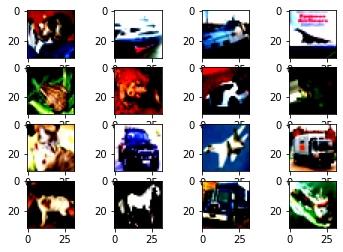

In [57]:
show_images(x_test[:16])

In [58]:
y_test[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [59]:
saved_model.predict(x_test[:16])

array([[2.13713429e-05, 1.89445818e-05, 5.67843090e-04, 2.55961120e-01,
        1.16128894e-03, 2.84828871e-01, 2.05766171e-01, 2.79797905e-06,
        2.51308829e-01, 3.62804189e-04],
       [4.36410937e-06, 6.01491511e-01, 6.52095600e-11, 6.24616026e-10,
        8.63144712e-12, 1.85499081e-11, 1.00112047e-07, 1.53814080e-11,
        3.97616982e-01, 8.87065020e-04],
       [1.90323126e-02, 2.35373512e-01, 9.88418324e-05, 1.40417338e-04,
        3.48904287e-05, 1.06555617e-05, 1.51782388e-05, 1.48685622e-05,
        6.86826646e-01, 5.84526286e-02],
       [2.18226039e-03, 2.28473189e-04, 2.57950102e-04, 9.70168571e-07,
        5.39658140e-06, 6.49292247e-08, 1.30294371e-04, 6.72654460e-06,
        9.85438228e-01, 1.17496988e-02],
       [6.88293511e-08, 1.35431965e-05, 1.90894341e-03, 2.67720848e-01,
        6.02578342e-01, 2.91383662e-03, 1.24719314e-01, 2.01027274e-06,
        1.36369054e-04, 6.75447700e-06],
       [2.73951883e-07, 6.65186519e-08, 2.04582975e-07, 6.54342875e-04,
   